## _*H2 ground state energy computation using Iterative QPE*_

This notebook demonstrates computing and graphing the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using `IQPE` (Iterative Quantum Phase Estimation) algorithm. It is compared to the ground-truth energies as computed by the `ExactEigensolver`.

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

First we define the `compute_energy` method, which contains the H2 molecule definition as well as the computation of its ground energy given the desired `distance` and `algorithm` (`i` is just a helper index for parallel computation to speed things up).

In [19]:
import pylab
import time
import numpy as np
import multiprocessing as mp
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance, AquaError
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.operators.op_converter import to_weighted_pauli_operator
from qiskit.aqua.algorithms.single_sample import IQPE
from qiskit.aqua.algorithms.single_sample import QPE
from qiskit.aqua.components.iqfts import Standard
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

def compute_energy(i, distance, algorithm):
    try:
        driver = PySCFDriver(
            atom='H .0 .0 .0; H .0 .0 {}'.format(distance),
            unit=UnitsType.ANGSTROM,
            charge=0,
            spin=0,
            basis='sto3g'
        )
    except:
        raise AquaError('PYSCF driver does not appear to be installed')
    molecule = driver.run()
    qubit_mapping = 'parity'
    fer_op = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubit_op = Z2Symmetries.two_qubit_reduction(to_weighted_pauli_operator(fer_op.mapping(map_type=qubit_mapping, threshold=1e-10)), 2)

    if algorithm.lower() == 'exacteigensolver':
        exact_eigensolver = ExactEigensolver(qubit_op, k=1)
        result = exact_eigensolver.run()
        reference_energy = result['energy']
    elif algorithm.lower() == 'iqpe':
        num_particles = molecule.num_alpha + molecule.num_beta
        two_qubit_reduction = True
        num_orbitals = qubit_op.num_qubits + (2 if two_qubit_reduction else 0)

        num_time_slices = 1
        num_iterations = 10
        state_in = HartreeFock(qubit_op.num_qubits, num_orbitals,
                               num_particles, qubit_mapping, two_qubit_reduction)
        iqpe = IQPE(qubit_op, state_in, num_time_slices, num_iterations,
                    expansion_mode='trotter', expansion_order=1,
                    shallow_circuit_concat=True)
        backend = BasicAer.get_backend('statevector_simulator')
        quantum_instance = QuantumInstance(backend)

        result = iqpe.run(quantum_instance)
    elif algorithm.lower() == 'qpe':
        num_particles = molecule.num_alpha + molecule.num_beta
        two_qubit_reduction = True
        num_orbitals = qubit_op.num_qubits + (2 if two_qubit_reduction else 0)

        num_time_slices = 1
        iqft = Standard(qubit_op.num_qubits)
        state_in = HartreeFock(qubit_op.num_qubits, num_orbitals,
                               num_particles, qubit_mapping, two_qubit_reduction)
        qpe = QPE(qubit_op, state_in, iqft, num_time_slices, num_ancillae=4,
                   expansion_mode='trotter', expansion_order=1,
                   shallow_circuit_concat=True)
        backend = BasicAer.get_backend('statevector_simulator')
        quantum_instance = QuantumInstance(backend)

        result = qpe.run(quantum_instance)
    else:
        raise AquaError('Unrecognized algorithm.')
    return i, distance, result['energy'] + molecule.nuclear_repulsion_energy, molecule.hf_energy

Next we set up the experiment to compute H2 ground energies for a range of inter-atomic distances, in parallel.

In [20]:
import concurrent.futures
import multiprocessing as mp

algorithms = ['iqpe', 'exacteigensolver', 'qpe']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 1   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

start_time = time.time()
for j in range(len(algorithms)):
    algorithm = algorithms[j]
    print(f'On algorithm {algorithm}')
    for i in range(steps+1):
        d = start + i*by/steps
        result = compute_energy(
            i, 
            d, 
            algorithm
        )
        i, d, energy, hf_energy = result
        energies[j][i] = energy
        hf_energies[i] = hf_energy
        distances[i] = d
        
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

On algorithm iqpe
On algorithm exacteigensolver
On algorithm qpe
 --- complete
Distances:  [0.5 1. ]
Energies: [[-1.04413391 -1.09001944]
 [-1.05515979 -1.10115033]
 [-0.94999264 -1.0546658 ]]
Hartree-Fock energies: [-1.04299627 -1.06610865]
--- 48.1447319984436 seconds ---


Finally we plot the results:

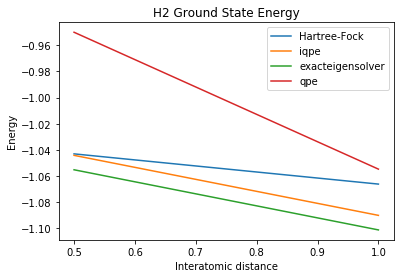

In [21]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')
pylab.show()

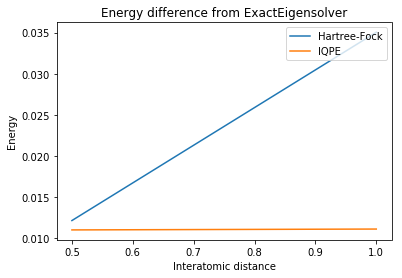

In [13]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='IQPE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper right')
pylab.show()

In [ ]:
import concurrent.futures
import multiprocessing as mp

algorithms = ['qpe']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 1   # Number of steps to increase by
reps=5
energies = np.empty([len(algorithms), steps+1, reps])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

start_time = time.time()
for j in range(len(algorithms)):
    for k in range(reps):
        algorithm = algorithms[j]
        print(f'On algorithm {algorithm}')
        for i in range(steps+1):
            d = start + i*by/steps
            result = compute_energy(
                i, 
                d, 
                algorithm
            )
            i, d, energy, hf_energy = result
            energies[j][i][k] = energy
            hf_energies[i] = hf_energy
            distances[i] = d
        
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

On algorithm qpe
On algorithm qpe
On algorithm qpe
On algorithm qpe
